In [1]:
from functions import *

Short display of the data.

In [2]:
FULL_DF = pd.read_csv("philosophy_data.csv", converters={"tokenized_sentence": pd.eval})

In [3]:
#Filter dataframe to training, test, fulldataset
train_data = 0.2
indexes = [i for i in list(FULL_DF.sample(frac=train_data).index)]
DF_TRAIN = FULL_DF.iloc[indexes]
DF_TRAIN.reset_index(drop = True, inplace = True)
DF_TEST = FULL_DF.iloc[~FULL_DF.index.isin(indexes)]
DF_TEST.reset_index(drop = True, inplace = True)

#Comment these to be able to train.
# DF_TEST = FULL_DF
# DF_TRAIN = FULL_DF

len(FULL_DF.index), len(DF_TEST.index), len(DF_TRAIN.index)

(328017, 262414, 65603)

In [4]:
DF_TRAIN.sample(2)

,school,author,title,tokenized_sentence,num_of_chars,num_of_words,string_sentence
61393,empiricism,John Locke,an essay concerning human understanding 1,"[whence, follow, principles, evident, others, ...",180,23,whence follow principles evident others teachi...
34216,analytic,Bertrand Russell,the analysis of mind,"[interests, school, general, philosophy, philo...",151,17,interests school general philosophy philosophy...


Extract the tokenized_sentence DF["tokenized_sentence"] sentences and append them into a python list.

Load w2v model, tf_idf, bigram, and trigram models and save them in respective

In [5]:
skipgram_w2v = Word2Vec(
            DF_TRAIN["tokenized_sentence"].tolist(),
            vector_size=100,       # Dimensionality of word embeddings
            sg = 1,                # SKIPGRAM
            window=5,              # Word window for context evaluation
            epochs=10)             # Number of epochs training over corpus

cbow_w2v = Word2Vec(
            DF_TRAIN["tokenized_sentence"].tolist(),
            vector_size=100,
            sg = 0,                # CBOW
            window=5,
            epochs=10)

len(skipgram_w2v.wv), len(cbow_w2v.wv)

(12444, 12444)

The sentence_vectorizer function summarizes each vectorized word in a sentence and divides the sum with the amount of words in the sentence.
Doing this will allow us to be able to get whole sentences vectorized values instead of individual words.
Using the function with our model (in this case w2v) sentences.
Can also be used with pretrained models.

In [6]:
DF_TEST, skipgram_sentences = vectorize_sentences(skipgram_w2v.wv, DF_TEST)
DF_TEST, cbow_sentences = vectorize_sentences(cbow_w2v.wv, DF_TEST)

#Should be equal
len(DF_TEST["tokenized_sentence"]), len(skipgram_sentences), len(cbow_sentences)

(260151, 260151, 260151)

Fetch the number of unique School of Thoughts.

In [7]:
unique_schools = DF_TEST["school"].unique().tolist()
print(unique_schools)
num_clusters = len(unique_schools)

['rationalism', 'analytic', 'empiricism', 'phenomenology', 'capitalism', 'continental', 'plato', 'aristotle', 'german_idealism', 'communism']


Bar plot how many sentences are from each School of Thought.
(Show the total amount of real assigned SOT on each text.)

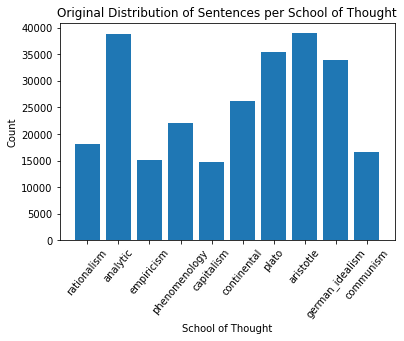

In [8]:
total_dict = dict.fromkeys(unique_schools, 0)
for school in DF_TEST["school"]:
    total_dict[school] += 1

plt.bar(range(len(total_dict)), total_dict.values(), align='center')
plt.xticks(range(len(total_dict)), total_dict.keys())
plt.xticks(rotation=50)
plt.xlabel("School of Thought")
plt.ylabel("Count")
plt.title("Original Distribution of Sentences per School of Thought")
plt.show()

Apply kmeans with num_clusters=amount of unique schools in the DF.

In [9]:
start = time.time()

#Skip-gram and cbow.
skipgram_w2v_kmeans, skipgram_w2v_labels, skipgram_w2v_centroids = apply_kmeans(num_clusters, skipgram_sentences)
cbow_w2v_kmeans, cbow_w2v_labels, cbow_w2v_centroids = apply_kmeans(num_clusters, cbow_sentences)

end = time.time()
print(end - start)

48.5706741809845


Apply scatter plot on kmeans results using TSNE.
Scatter plot using TSNE, PCA and UMAP

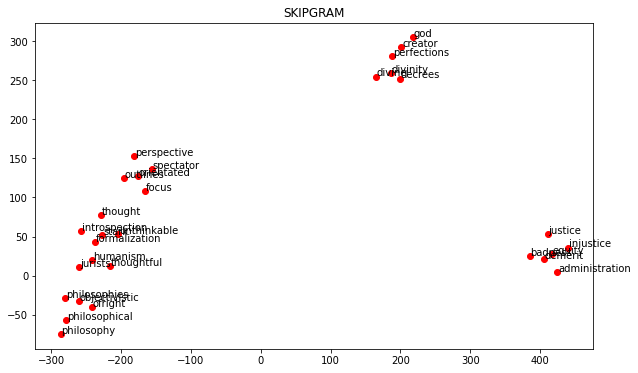

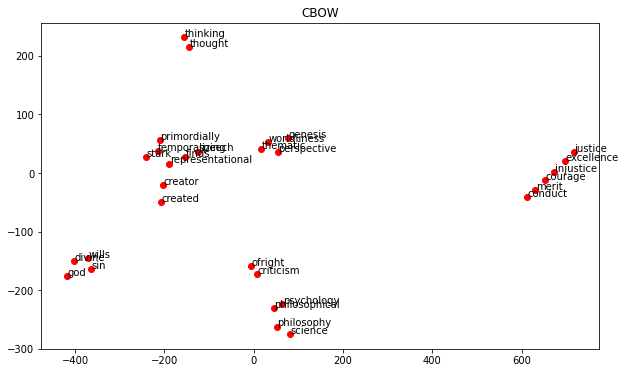

In [10]:
# scatter_plot(type='pca', labels=skipgram_w2v_labels, values=skipgram_sentences)
# scatter_plot(type='pca', labels=cbow_w2v_labels, values=cbow_sentences)

words = ['god', 'philosophy', 'justice', 'thought', 'perspective']
plot_similar_words(skipgram_w2v.wv, words, title="SKIPGRAM",top_words=5)
plot_similar_words(cbow_w2v.wv, words,title="CBOW", top_words=5)

Combine the kmeans clustering results with the labels.
Put the kmeans result in a dictionary:

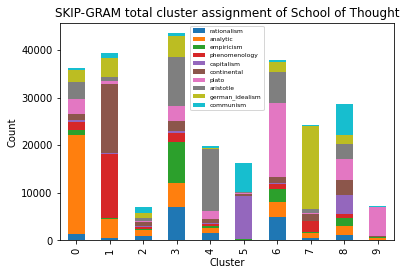

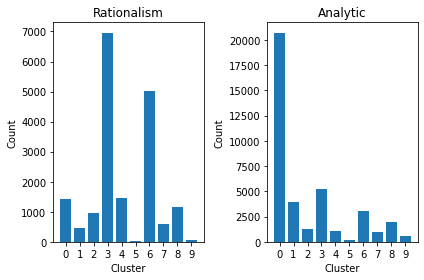

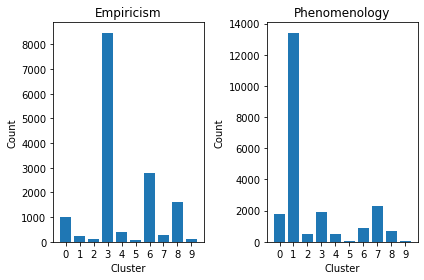

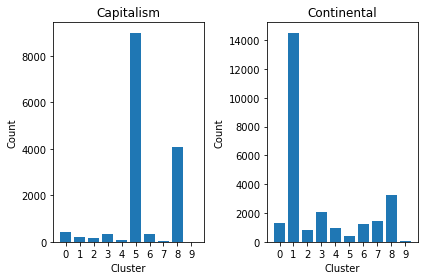

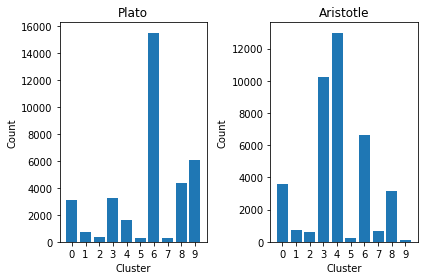

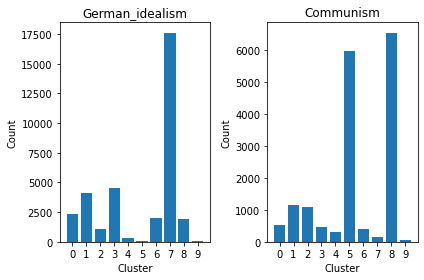

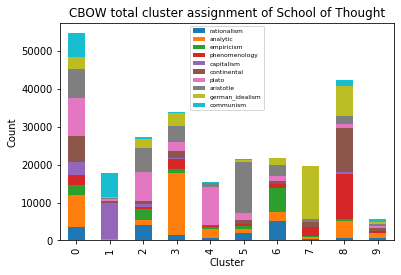

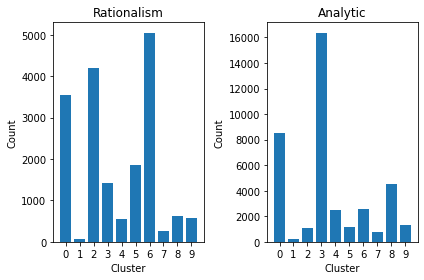

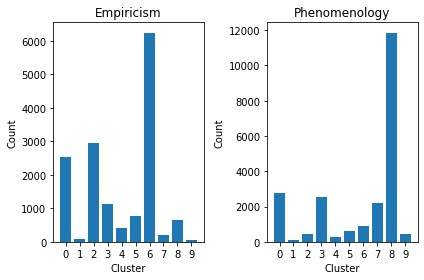

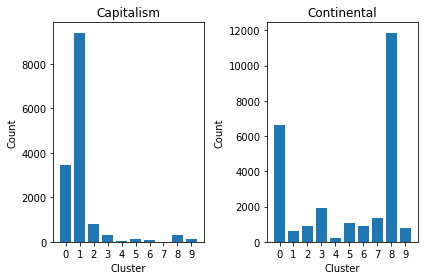

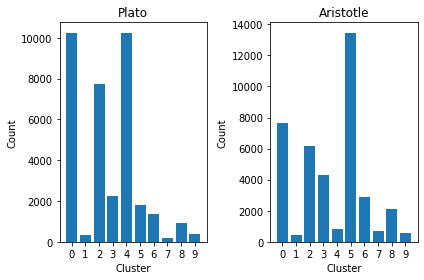

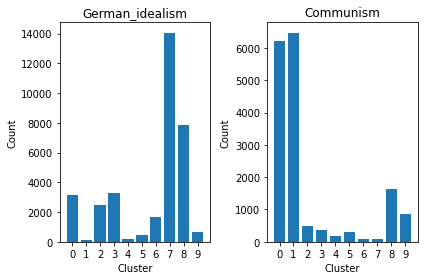

In [11]:
#How many times cluster n was assigned to specific SOT
cluster_n_assigned(DF=DF_TEST, labels=skipgram_w2v_labels, schools=unique_schools, name='skip-gram')
cluster_n_assigned(DF=DF_TEST, labels=cbow_w2v_labels, schools=unique_schools, name='cbow')

Make a list and convert all "plato" to 0 and "aristotle" to 1, etc.
This can then be applied with the predicted labels with v_measure.

In [12]:
original_labels = [unique_schools.index(school) for school in DF_TEST["school"]]

Apply v-measure.

In [13]:
#w2v
skipgram_v_measure = v_measure_score(original_labels, skipgram_w2v_labels)
cbow_v_measure = v_measure_score(original_labels, cbow_w2v_labels)

skipgram_v_measure, cbow_v_measure

(0.2781386937386959, 0.22992179413310637)

Calculate the best v_measure.
Apply different values for window/epoch.

In [21]:
#If want to train models on full corpus
train = True
#Iterations
iterations = 2
epochs = 5

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.2,iterations=iterations, window=2, epochs=epochs, vector_size=100, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.2,iterations=iterations, window=2, epochs=epochs, vector_size=100, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.2,iterations=iterations, window=3, epochs=epochs, vector_size=100, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.2,iterations=iterations, window=3, epochs=epochs, vector_size=100, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.2,iterations=iterations, window=5, epochs=epochs, vector_size=100, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.2,iterations=iterations, window=5, epochs=epochs, vector_size=100, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.2,iterations=iterations, window=7, epochs=epochs, vector_size=100, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.2,iterations=iterations, window=7, epochs=epochs, vector_size=100, model=0)

Print v_measure values


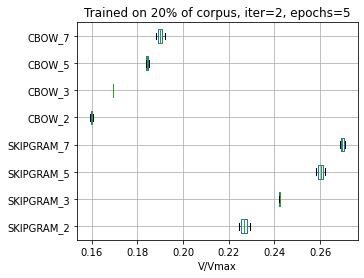

In [22]:
v_measure_dict_trained = {"skipgram_2": v_measure_list_skipgram_2,
                          "skipgram_3": v_measure_list_skipgram_3,
                          "skipgram_5": v_measure_list_skipgram_5,
                          "skipgram_7": v_measure_list_skipgram_7,
                          "cbow_2": v_measure_list_cbow_2,
                          "cbow_3": v_measure_list_cbow_3,
                          "cbow_5": v_measure_list_cbow_5,
                          "cbow_7": v_measure_list_cbow_7}

plot_v_measure(v_measure_dict_trained, title=f"Trained on 20% of corpus, iter={iterations}, epochs={epochs}")

In [23]:
max(v_measure_dict_trained["skipgram_2"]), max(v_measure_dict_trained["skipgram_3"]), max(v_measure_dict_trained["skipgram_5"]), max(v_measure_dict_trained["skipgram_7"])

(0.2291282950498668,
 0.2424372069484137,
 0.2622371979208341,
 0.2708946730568987)

In [24]:
max(v_measure_dict_trained["cbow_2"]), max(v_measure_dict_trained["cbow_3"]), max(v_measure_dict_trained["cbow_5"]), max(v_measure_dict_trained["cbow_7"])

(0.16073437211519812,
 0.16952778726104642,
 0.18494943563275887,
 0.19192704665314833)

In [25]:
#Average
sum(v_measure_dict_trained["skipgram_2"])/len(v_measure_dict_trained["skipgram_2"]), sum(v_measure_dict_trained["skipgram_3"])/len(v_measure_dict_trained["skipgram_3"]), sum(v_measure_dict_trained["skipgram_5"])/len(v_measure_dict_trained["skipgram_5"]), sum(v_measure_dict_trained["skipgram_7"])/len(v_measure_dict_trained["skipgram_7"])

(0.22672954130209688,
 0.24225163754623752,
 0.2602119009869746,
 0.2697311124310354)

In [26]:
sum(v_measure_dict_trained["cbow_2"])/len(v_measure_dict_trained["cbow_2"]), sum(v_measure_dict_trained["cbow_3"])/len(v_measure_dict_trained["cbow_3"]), sum(v_measure_dict_trained["cbow_5"])/len(v_measure_dict_trained["cbow_5"]), sum(v_measure_dict_trained["cbow_7"])/len(v_measure_dict_trained["cbow_7"])

(0.1599251519635341,
 0.16945353660116644,
 0.18427639104201166,
 0.18998239426491087)

In [27]:
#If want to train models on full corpus
train = False
#Iterations
iterations = 2
epochs = 5

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.2,iterations=iterations, window=2, epochs=epochs, vector_size=100, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.2,iterations=iterations, window=2, epochs=epochs, vector_size=100, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.2,iterations=iterations, window=3, epochs=epochs, vector_size=100, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.2,iterations=iterations, window=3, epochs=epochs, vector_size=100, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.2,iterations=iterations, window=5, epochs=epochs, vector_size=100, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.2,iterations=iterations, window=5, epochs=epochs, vector_size=100, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.2,iterations=iterations, window=7, epochs=epochs, vector_size=100, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.2,iterations=iterations, window=7, epochs=epochs, vector_size=100, model=0)

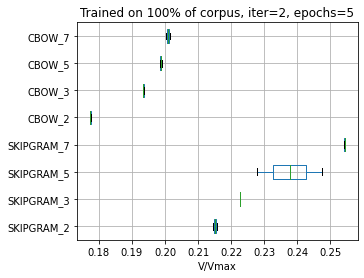

In [28]:
v_measure_dict_full = {"skipgram_2": v_measure_list_skipgram_2,
                       "skipgram_3": v_measure_list_skipgram_3,
                       "skipgram_5": v_measure_list_skipgram_5,
                       "skipgram_7": v_measure_list_skipgram_7,
                       "cbow_2": v_measure_list_cbow_2,
                       "cbow_3": v_measure_list_cbow_3,
                       "cbow_5": v_measure_list_cbow_5,
                       "cbow_7": v_measure_list_cbow_7}

plot_v_measure(v_measure_dict_full, title=f"Trained on 100% of corpus, iter={iterations}, epochs={epochs}")

In [29]:
max(v_measure_dict_full["skipgram_2"]), max(v_measure_dict_full["skipgram_3"]), max(v_measure_dict_full["skipgram_5"]), max(v_measure_dict_full["skipgram_7"])

(0.21563956949947768,
 0.22266407178012454,
 0.24755720525040786,
 0.2544400682471628)

In [30]:
max(v_measure_dict_full["cbow_2"]), max(v_measure_dict_full["cbow_3"]), max(v_measure_dict_full["cbow_5"]), max(v_measure_dict_full["cbow_7"])

(0.17763821806240102,
 0.19359099506222774,
 0.19899860672635072,
 0.20159528120235817)

In [31]:
#Average
sum(v_measure_dict_full["skipgram_2"])/len(v_measure_dict_full["skipgram_2"]), sum(v_measure_dict_full["skipgram_3"])/len(v_measure_dict_full["skipgram_3"]), sum(v_measure_dict_full["skipgram_5"])/len(v_measure_dict_full["skipgram_5"]), sum(v_measure_dict_full["skipgram_7"])/len(v_measure_dict_full["skipgram_7"])

(0.21504803180198662,
 0.2226181938215778,
 0.23766379100682894,
 0.25431353057316586)

In [32]:
sum(v_measure_dict_full["cbow_2"])/len(v_measure_dict_full["cbow_2"]), sum(v_measure_dict_full["cbow_3"])/len(v_measure_dict_full["cbow_3"]), sum(v_measure_dict_full["cbow_5"])/len(v_measure_dict_full["cbow_5"]), sum(v_measure_dict_full["cbow_7"])/len(v_measure_dict_full["cbow_7"])

(0.17742756574629198,
 0.19347255962058063,
 0.19866512490813415,
 0.20094700626914752)